# Data Exploration

In [6]:
import helper as hp
import numpy as np

In [7]:
train_X, test_X, train_y, test_y, test, labels, classes = hp.initData() #Getting test and train data

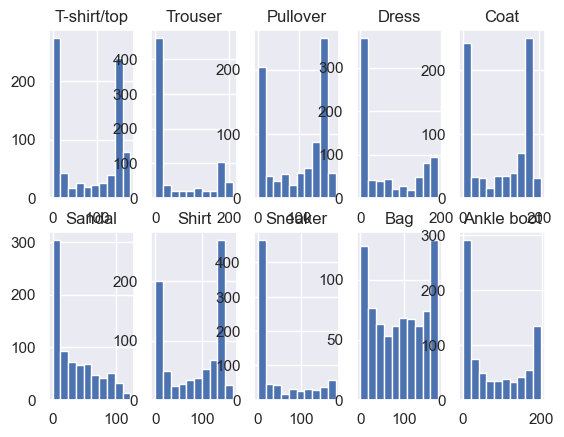

In [8]:
hp.dataDistribution(plot="intHist") 

Extra Analysis

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = np.load("./Data/train_images.npy")
data = data/255
data = data.reshape(data.shape[0], -1) 
labels = pd.read_csv("./Data/train_labels.csv").values

In [4]:
import umap
embedding = umap.UMAP().fit_transform(data, y=labels)

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[-2.5498226  6.9158134  3.9171312 ... -1.8988494  4.2171407 10.855908 ]


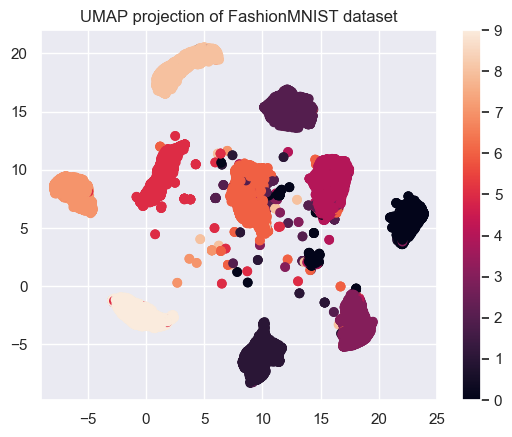

In [10]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(ticks=np.arange(10))
plt.title('UMAP projection of FashionMNIST dataset')
plt.show()

# Model Exploration

In [15]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall, CategoricalAccuracy
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [11]:
y_sparse_train = [[0 if train_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(train_y))]
y_sparse_train = np.array(y_sparse_train)
y_sparse_test = [[0 if test_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(test_y))]
y_sparse_test = np.array(y_sparse_test)

Base model (before enhancement)

In [18]:
callbackES = EarlyStopping(monitor="categorical_accuracy", patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(BatchNormalization())
model.add(Dense(50, activation="elu", kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 50)                39250     
                                                                 
 batch_normalization_3 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 43,096
Trainable params: 41,428
Non-trai

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [19]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0002), metrics=[CategoricalAccuracy(), AUC(), Precision(), Recall()])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 32, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6127 - categorical_accuracy: 0.7935 - auc_2: 0.9785 - precision_2: 0.8663 - recall_2: 0.7183 - val_loss: 0.4571 - val_categorical_accuracy: 0.8399 - val_auc_2: 0.9868 - val_precision_2: 0.8784 - val_recall_2: 0.7967
Epoch 2/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.4571 - categorical_accuracy: 0.8395 - auc_2: 0.9872 - precision_2: 0.8797 - recall_2: 0.8008 - val_loss: 0.4153 - val_categorical_accuracy: 0.8526 - val_auc_2: 0.9889 - val_precision_2: 0.8874 - val_recall_2: 0.8193
Epoch 3/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.4190 - categorical_accuracy: 0.8530 - auc_2: 0.9890 - precision_2: 0.8867 - recall_2: 0.8192 - val_loss: 0.3886 - val_categorical_accuracy: 0.8630 - val_auc_2: 0.9900 - val_precision_2: 0.8916 - val_recall_2: 0.8344
Epoch 4/20
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3942 - categorical_accuracy: 0.8615 - au

In [20]:
model.save("./Model/FashionMNISTBase")

INFO:tensorflow:Assets written to: ./Model/FashionMNISTBase\assets


INFO:tensorflow:Assets written to: ./Model/FashionMNISTBase\assets


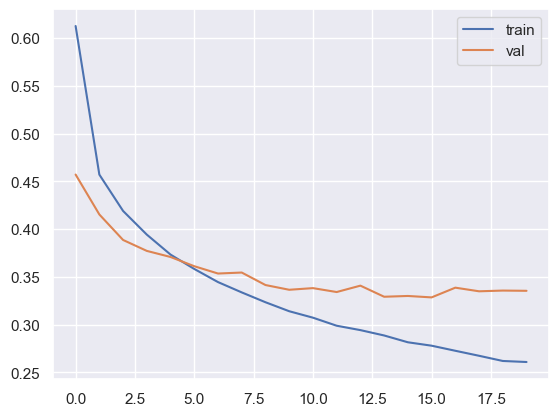

In [21]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

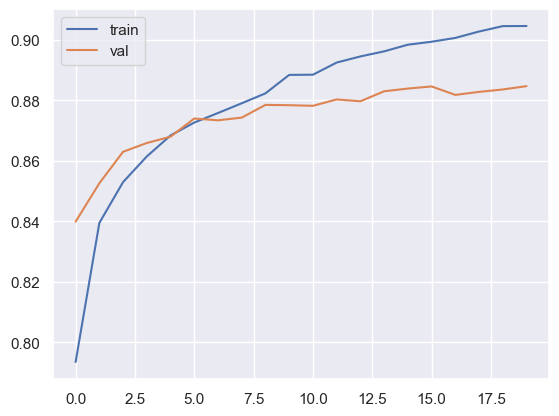

In [24]:
plt.plot(history.history["categorical_accuracy"], label="train")
plt.plot(history.history["val_categorical_accuracy"], label="val")
plt.legend()
plt.show()

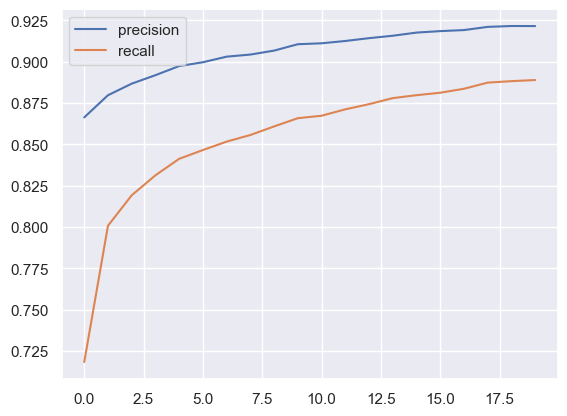

In [27]:
plt.plot(history.history["precision_2"], label="precision")
plt.plot(history.history["recall_2"], label="recall")
plt.legend()
plt.show()

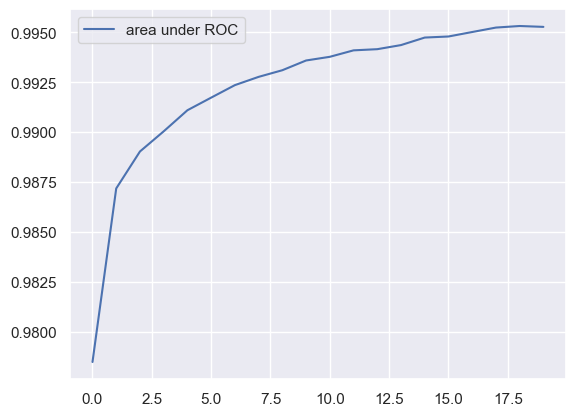

In [29]:
plt.plot(history.history["auc_2"], label="area under ROC")
plt.legend()
plt.show()

313/313 [==============================] - 0s 1ms/step


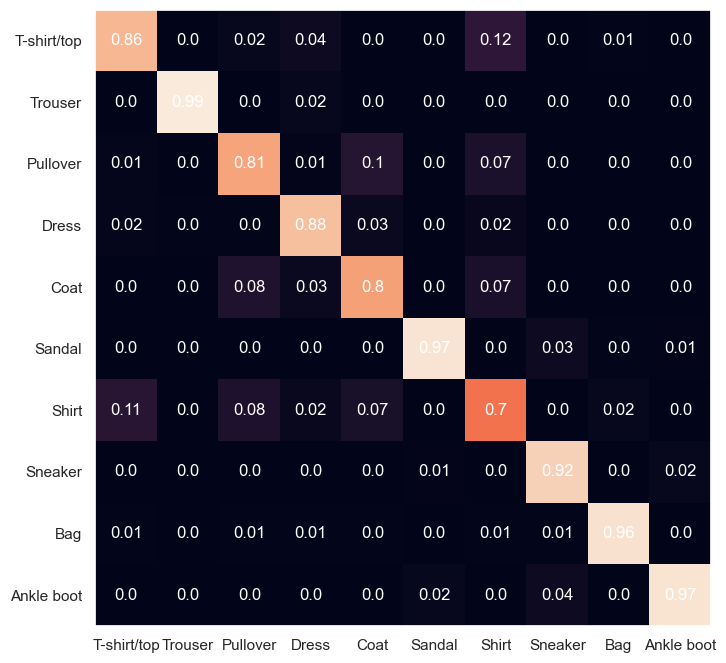

In [57]:
from sklearn.metrics import confusion_matrix

y_prediction = model.predict(test_X)
y_prediction = np.argmax(y_prediction, axis = 1)
result = confusion_matrix(test_y, y_prediction, normalize='pred')

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(result)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
plt.grid(None)

# Loop over data dimensions and create text annotations.
for i in range(len(result)):
    for j in range(len(result)):
        text = ax.text(j, i, np.round(result[i, j],2),
                       ha="center", va="center", color="w")

In [62]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_prediction, digits=3))

              precision    recall  f1-score   support

           0      0.855     0.820     0.837      1023
           1      0.990     0.974     0.982       988
           2      0.809     0.796     0.802      1008
           3      0.876     0.924     0.899      1021
           4      0.801     0.820     0.810      1050
           5      0.971     0.948     0.959       996
           6      0.697     0.692     0.694       970
           7      0.921     0.970     0.945       955
           8      0.964     0.962     0.963       968
           9      0.969     0.948     0.958      1021

    accuracy                          0.885     10000
   macro avg      0.885     0.885     0.885     10000
weighted avg      0.885     0.885     0.885     10000



# Model Enhancement

## Accuracy vs LR

La prueba se realizo dos veces para un ajuste mas fino del LR

In [121]:
model = load_model("./Model/FashionMNISTBase")
lr = 0.0000016
acc_valResults = []

for i in range(10):
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=lr), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 32, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    lr = lr/5


Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2576 - accuracy: 0.9070 - val_loss: 0.3423 - val_accuracy: 0.8808
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2499 - accuracy: 0.9085 - val_loss: 0.3463 - val_accuracy: 0.8817
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2473 - accuracy: 0.9112 - val_loss: 0.3467 - val_accuracy: 0.8825
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2475 - accuracy: 0.9106 - val_loss: 0.3672 - val_accuracy: 0.8819
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2448 - accuracy: 0.9121 - val_loss: 0.3427 - val_accuracy: 0.8826
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2440 - accuracy: 0.9118 - val_loss: 0.3438 - val_accuracy: 0.8835
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2442 - accuracy: 0.9114 - val_loss: 0.3611 - val_accuracy:

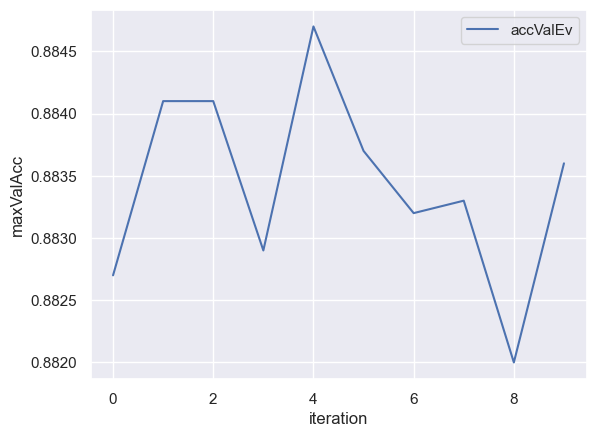

In [122]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## Accuracy vs Batchsize


In [134]:
bz = 32
acc_valResults = []

for i in range(5):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = bz, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    bz = bz*2

Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2638 - accuracy: 0.9051 - val_loss: 0.3458 - val_accuracy: 0.8823
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2567 - accuracy: 0.9078 - val_loss: 0.3463 - val_accuracy: 0.8824
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2581 - accuracy: 0.9062 - val_loss: 0.3385 - val_accuracy: 0.8831
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2569 - accuracy: 0.9084 - val_loss: 0.3397 - val_accuracy: 0.8830
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2550 - accuracy: 0.9077 - val_loss: 0.3392 - val_accuracy: 0.8832
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2533 - accuracy: 0.9099 - val_loss: 0.3403 - val_accuracy: 0.8827
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2547 - accuracy: 0.9086 - val_loss: 0.3396 - val_accuracy:

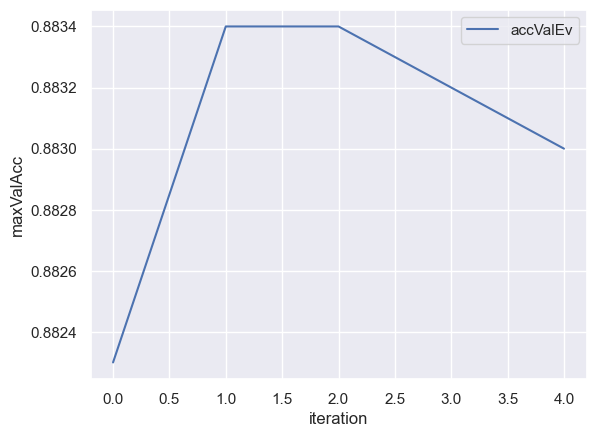

In [135]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

In [136]:
opts = [SGD(0.0000016), RMSprop(0.0000016), Adam(0.0000016), Adagrad(0.0000016)]
acc_valResults = []

for i in range(4):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=opts[i], metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 64, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/10
782/782 [==============================] - 4s 4ms/step - loss: 0.2457 - accuracy: 0.9108 - val_loss: 0.3537 - val_accuracy: 0.8798
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3454 - val_accuracy: 0.8801
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3430 - val_accuracy: 0.8805
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2462 - accuracy: 0.9105 - val_loss: 0.3443 - val_accuracy: 0.8805
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2460 - accuracy: 0.9105 - val_loss: 0.3437 - val_accuracy: 0.8804
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2455 - accuracy: 0.9111 - val_loss: 0.3427 - val_accuracy: 0.8806
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3431 - val_accuracy: 0.8812
Epoch 

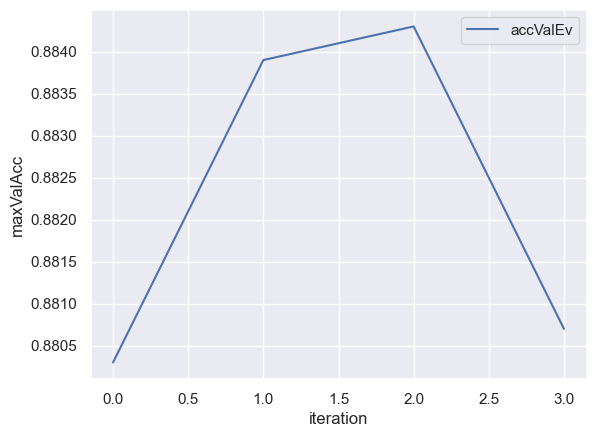

In [137]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## Accuracy vs Activations

In [153]:
activs = ["exponential","relu", "elu", "sigmoid", "tanh", "selu"]

for i in range(len(activs)):
    callbackES = EarlyStopping(monitor='accuracy', patience=3)
    initializer = GlorotNormal()
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(BatchNormalization())
    model.add(Dense(40, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 64, epochs=100)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/100
782/782 [==============================] - 4s 4ms/step - loss: 2.8342 - accuracy: 0.1132 - val_loss: 6.0838 - val_accuracy: 0.1407
Epoch 2/100
782/782 [==============================] - 3s 4ms/step - loss: 2.5147 - accuracy: 0.1796 - val_loss: 8.7870 - val_accuracy: 0.2162
Epoch 3/100
782/782 [==============================] - 3s 4ms/step - loss: 2.2484 - accuracy: 0.2506 - val_loss: 5.9614 - val_accuracy: 0.3128
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 2.0337 - accuracy: 0.3242 - val_loss: 4.8690 - val_accuracy: 0.3816
Epoch 5/100
782/782 [==============================] - 3s 3ms/step - loss: 1.8732 - accuracy: 0.3796 - val_loss: 668.4653 - val_accuracy: 0.4229
Epoch 6/100
782/782 [==============================] - 3s 4ms/step - loss: 1.7445 - accuracy: 0.4277 - val_loss: 2.4605 - val_accuracy: 0.4649
Epoch 7/100
782/782 [==============================] - 3s 4ms/step - loss: 1.6435 - accuracy: 0.4660 - val_loss: 5.7447 - val_accuracy: 0.49

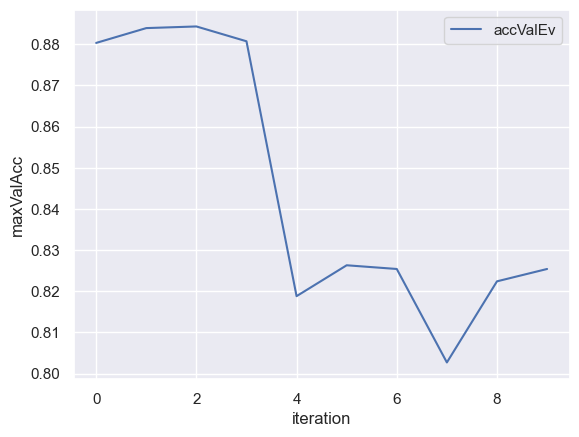

In [154]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

# Model Enhanced Analysis 

In [117]:
import tensorflow_addons as tfa
import tensorflow as tf

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [122]:
BATCH_SIZE = 128
INIT_LR = 0.0002
MAX_LR = 0.002

In [123]:
steps_per_epoch = len(train_X) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_accuracy",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 20,
                      max_lr = MAX_LR)


callbackES = EarlyStopping(monitor='val_accuracy', patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dropout_4 (Dropout)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               78500     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [124]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(callbackCLR), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)

Epoch 1/200
391/391 [==============================] - 2s 4ms/step - loss: 0.7508 - accuracy: 0.7443 - val_loss: 0.4948 - val_accuracy: 0.8221 - lr: 0.0011
Epoch 2/200
391/391 [==============================] - 1s 4ms/step - loss: 0.4830 - accuracy: 0.8280 - val_loss: 0.4284 - val_accuracy: 0.8502 - lr: 0.0020
Epoch 3/200
391/391 [==============================] - 1s 4ms/step - loss: 0.4254 - accuracy: 0.8442 - val_loss: 0.3847 - val_accuracy: 0.8625 - lr: 0.0011
Epoch 4/200
391/391 [==============================] - 1s 4ms/step - loss: 0.3879 - accuracy: 0.8596 - val_loss: 0.3698 - val_accuracy: 0.8666 - lr: 2.0346e-04
Epoch 5/200
391/391 [==============================] - 1s 4ms/step - loss: 0.3754 - accuracy: 0.8628 - val_loss: 0.3626 - val_accuracy: 0.8701 - lr: 6.5462e-04
Epoch 6/200
391/391 [==============================] - 2s 4ms/step - loss: 0.3755 - accuracy: 0.8639 - val_loss: 0.3577 - val_accuracy: 0.8696 - lr: 0.0011
Epoch 7/200
391/391 [==============================] - 1

In [125]:
model.save("./Model/FashionMNISTEnhanced")

INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


In [126]:
model = load_model("./Model/FashionMNISTEnhanced", compile=False)
toSubmit = pd.DataFrame(columns=["id","Category"])
toSubmit["id"] = np.arange(len(test))
toSubmit["Category"] = np.argmax(model.predict(test), (1))
toSubmit.to_csv("./Submit/sub1.csv", index=False)

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 0s 1ms/step


## Aditionals

In [136]:
steps_per_epoch = len(train_X) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_accuracy",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 20,
                      min_lr = MAX_LR)


callbackES = EarlyStopping(monitor='val_accuracy', patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(Dense(2, kernel_initializer=initializer, name='twinCity'))
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dropout_14 (Dropout)        (None, 784)               0         
                                                                 
 dense_31 (Dense)            (None, 100)               78500     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 twinCity (Dense)            (None, 2)                 202       
                                                                 
 dense_32 (Dense)            (None, 10)                30        
                                                                 
Total params: 78,732
Trainable params: 78,732
Non-tra

In [137]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(callbackCLR), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)

Epoch 1/200
391/391 [==============================] - 3s 5ms/step - loss: 1.5221 - accuracy: 0.3701 - val_loss: 1.0317 - val_accuracy: 0.5833 - lr: 0.0011
Epoch 2/200
391/391 [==============================] - 2s 5ms/step - loss: 0.8409 - accuracy: 0.6816 - val_loss: 0.7141 - val_accuracy: 0.7262 - lr: 0.0020
Epoch 3/200
391/391 [==============================] - 2s 4ms/step - loss: 0.6720 - accuracy: 0.7426 - val_loss: 0.6272 - val_accuracy: 0.7807 - lr: 0.0011
Epoch 4/200
391/391 [==============================] - 2s 4ms/step - loss: 0.6175 - accuracy: 0.7630 - val_loss: 0.5942 - val_accuracy: 0.7843 - lr: 2.0346e-04
Epoch 5/200
391/391 [==============================] - 2s 5ms/step - loss: 0.5962 - accuracy: 0.7730 - val_loss: 0.5826 - val_accuracy: 0.7851 - lr: 6.5462e-04
Epoch 6/200
391/391 [==============================] - 2s 4ms/step - loss: 0.5843 - accuracy: 0.7787 - val_loss: 0.5590 - val_accuracy: 0.7974 - lr: 0.0011
Epoch 7/200
391/391 [==============================] - 2

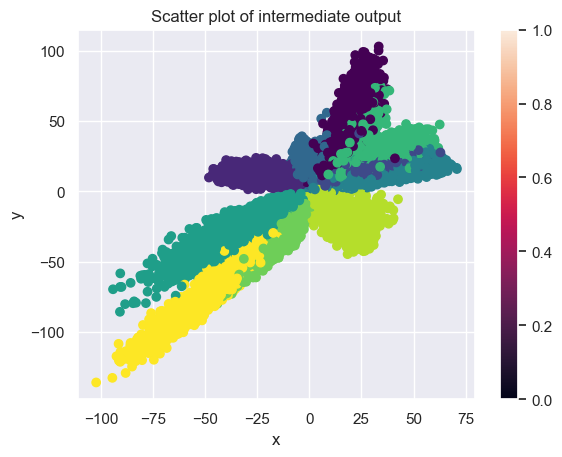

In [152]:
layer_name = 'twinCity'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(train_X)
# Extract the x and y coordinates of the intermediate output
x = intermediate_output[:, 0]
y = intermediate_output[:, 1]

# Define a color map based on the values of train_y
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(train_y.min(), train_y.max())
colors = cmap(norm(train_y))

# Create the scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=colors)
fig.colorbar(scatter)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Scatter plot of intermediate output')
plt.show()